# Introduction to synthetic experimentation

This notebook introduces the concept of synthetic experiments and demonstrates how to implement one using Python. 

Synthetic experiments are a powerful tool for studying the relationship between independent variables (factors) and dependent variables (observations) in an controlled environment. They allow us to generate data that resembles real-world data but is not as complex as data collected in the real world while being also free from the limitations, costs and biases that can arise from collecting data in the real world. 

This way, the later introduced concepts and algorithms from the 'Optimizing Experimental Design' course can be implemented, tested and validated easily. 

In this tutorial, you will learn how to:

- Define a ground truth function that represents the true relationship between the independent and dependent variables.
- Generate noisy data by adding noise to the true function values.
- Define treatments and experimental units which will serve as the base for collecting data
- Generating a dataset by defining a sample size, different treatments and eventually collecting samples.
- Run a model recovery to fit a model to the collected data and recover the parameters of the ground truth function.
- Get a feeling for the recovered model quality in dependence of the sample size and noise level

You will also explore how to experiment with different noise levels, sample sizes, and conditions to see how they affect the results of the model recovery.

By the end of this tutorial, you will have a strong understanding of how to implement and analyze synthetic experiments using Python.

## Import all the relevant libraries and package

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import Callable, Iterable

np.random.seed(42)

## Implementing a ground truth

In this section we will implement a ground truth which will serve us later to generate the observations.

In this section, you will learn to:
- Implement the ground truth method that models the relationship between the independent variables (factors) and the dependent variable (observation).
- Implement a method that generates noise and add it to the output of the ground truth
- Implement a class, whose instances will resemble the experimental units (e.g. participants)
- Create experimental units given sets of parameters and generate first observations

### Implement a ground truth

The ground truth can be any mathematical expression that takes in the independent variables as arguments and returns the dependent variable.

In our case, we will model a 2-factor ground truth with the two factors 'x' and 'y' and their respective parameters.

Replace the variable 'dependent_variable' which is currently 'None' with the actual value.

In [4]:
def ground_truth(x, y, parameters=np.ones(2,)):
    """This ground truth takes in two factors and a set of parameters and returns a response

    Args:
        x (float): The level of the first factor
        y (float): the level of the second factor
        parameters (Iterable[float], optional): The parameters give an individual configuration for each experimental unit. Defaults to np.ones(2,).

    Returns:
        float: Dependent variable which serves as the response
    """
    
    # this is an example of a ground truth function with two linear terms and a constant term 
    dependent_variable = parameters[0] * x + parameters[1] * y + parameters[0] - parameters[1]
    
    return dependent_variable

Test your ground truth by giving it random values and check if it has the desired properties.

Replace now the None-values with your own factor levels and parameters.

This code takes in the defined values for x, y and the parameters and outputs a 3D-plot of the observation over the given conditions.

Leave the code after defining the necessary value untouched so you get the 3D-plot.

Example:

```x = np.arange(1, 10)```

```y = np.arange(1, 10)```

```parameters = [1, 2]```

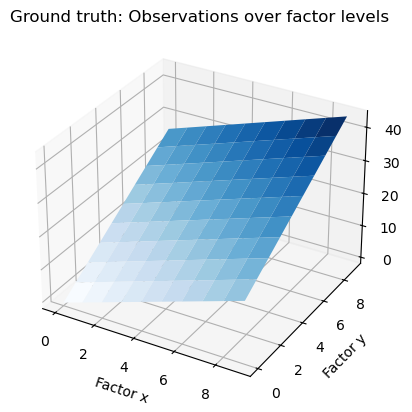

In [5]:
# define the factor levels
# you can use numpy arrays, lists or tuples
x = np.arange(0,10)
y = np.arange(0,10)
parameters = [2, 3]

# PLEASE DO NOT TOUCH THE CODE FROM HERE!

# set a sample size
sample_size = len(x)

# initiate the z array
z = np.zeros((sample_size, sample_size))

# collect the observations
x, y = np.meshgrid(x, y)
for i in range(sample_size):
    z[i, :] = ground_truth(x[i], y[i], parameters)

# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z, cmap=cm.Blues)
ax.set_title('Ground truth: Observations over factor levels')
ax.set_xlabel('Factor x')
ax.set_ylabel('Factor y')
plt.show()

Does it look good? Well, then let's move to the next part!

## Implementing a noise signal

The noise signal is a value drawn from a normal distribution. 

It will be multiplied by a specified noise level and later be added to the dependent variable to get the final observation.

The scale of normal distribution should be $0.1$

This way we get the inherent noise, which basically any experiment comes with.

Tip: numpy comes already with a method that draws values from a random distribution. Use that one! Call it with np.random.normal(mean, scale)

In [7]:
def noise(noise_level):

    # add your code here:
    
    # draw a value from a normal distribution
    noise = np.random.normal(0, 1)
    
    # multiply it with the noise_level before returning it. 
    # This way we will later have control over the noise magnitude without changing the code.
    noise *= noise_level
    
    return noise

Let's check if the noise looks as we expect it to be:

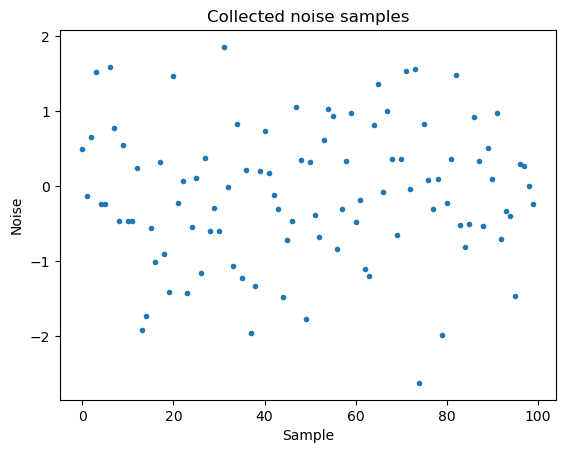

In [8]:
noise_level = 1

noise_sample_size = 100
noise_samples = np.zeros(noise_sample_size)

for i in range(noise_sample_size):
    noise_samples[i] = noise(noise_level=1)
    
plt.plot(noise_samples, '.')
plt.title('Collected noise samples')
plt.ylabel('Noise')
plt.xlabel('Sample')
plt.show()

Now let's add some noise to the observations and compare the previous observations without noise with the current noisy ones

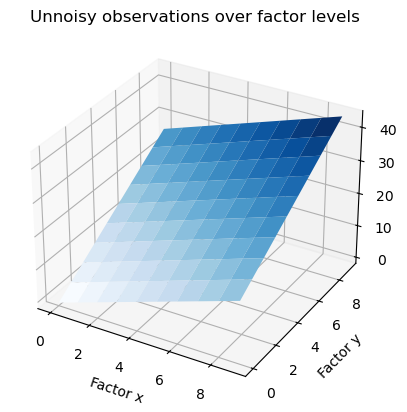

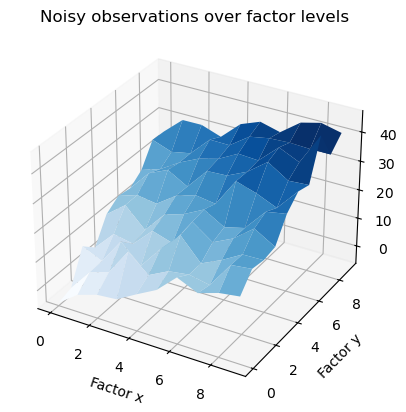

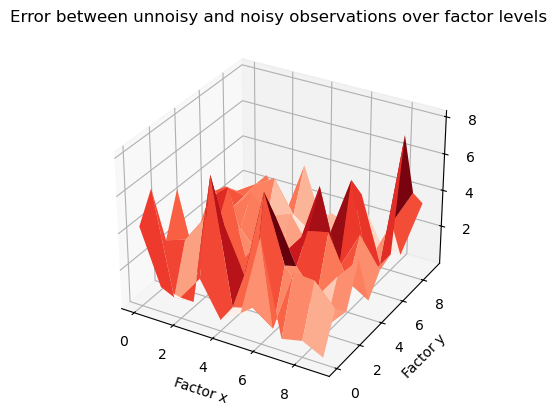

In [9]:
# set noise level
noise_level = 3

# initiate the noisy z array
z_noisy = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    z_noisy[i, :] = ground_truth(x[i], y[i], parameters)
    
# add noise
for i in range(z_noisy.shape[0]):
    for j in range(z_noisy.shape[1]):
        z_noisy[i, j] += noise(noise_level)

# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z, cmap=cm.Blues)
ax.set_title('Unnoisy observations over factor levels')
ax.set_xlabel('Factor x')
ax.set_ylabel('Factor y')
plt.show()

# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z_noisy, cmap=cm.Blues)
ax.set_title('Noisy observations over factor levels')
ax.set_xlabel('Factor x')
ax.set_ylabel('Factor y')
plt.show()

# make a plot of the difference between the unnoisy and the noisy signal
z_error = np.abs(z - z_noisy)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z_error, cmap=cm.Reds)
ax.set_title('Error between unnoisy and noisy observations over factor levels')
ax.set_xlabel('Factor x')
ax.set_ylabel('Factor y')
plt.show()

Does your noise function look good? If so, great! Let's go to the next section then!

## Implementing an experimental unit class

Here you will implement a class for experimental units.

In the psychological context, experimental units refer to individual participants or groups of participants which get the same treatment.

These participants are similar in terms of the basic cognitive functions which are used to solve a problem but may differ in e.g. skill.

To account for these differences between participants, we will now implement a class which takes in:
- a problem_solver method which refers to the ground_truth method, you already implemented.
- a noise method which you already implemented as well.
- a parameter set, to account for the differences inbetween the participants

In [10]:
class experimental_unit:
    
    def __init__(self,
        problem_solver: Callable, 
        noise: Callable, 
        parameters: Iterable, 
        noise_level: float = 1,
        ):
        
        self.problem_solver_fun = problem_solver
        self.noise_fun = noise
        self.parameters = parameters
        self.noise_level = noise_level
        
    def problem_solver(self, x, y):
        # this method returns the dependent variable based on the independent variables x and y and the parameters
        return self.problem_solver_fun(x, y, self.parameters)
    
    def noise(self, noise_level=None):
        # this method returns the noise
        if noise_level == None:
            noise_level = self.noise_level
            
        return self.noise_fun(noise_level)
    
    def step(self, x, y, noise=True):
        # this method returns the observation which is the sum of the dependent variable and the noise
        if noise:
            return self.problem_solver(x, y) + self.noise()
        else:
            return self.problem_solver(x, y)

Create two instances (individual participants) of the the 'experimental unit' class with different parameters and compare the collected observations.

In the first step we won't add any noise so we get a feeling on how parameters influence the observations

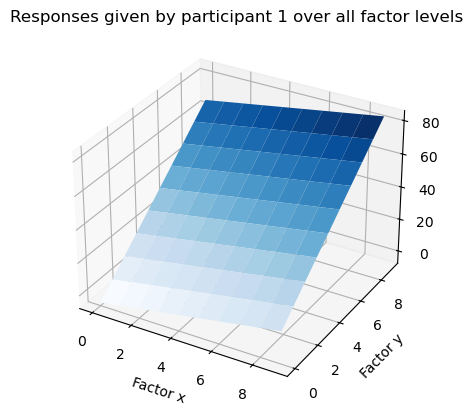

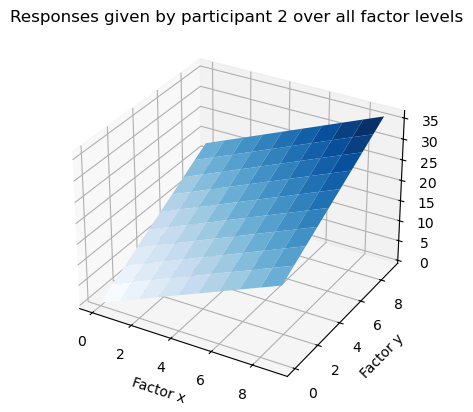

In [15]:
# replace None with your own treatment combinations
parameters_participant1 = [2, 8]
parameters_participant2 = [2, 2]

# Create two experimental units with different parameters
participant1 = experimental_unit(
    problem_solver=ground_truth,
    noise=noise,
    parameters=parameters_participant1,
    noise_level=0,
)

participant2 = experimental_unit(
    problem_solver=ground_truth,
    noise=noise,
    parameters=parameters_participant2,
    noise_level=0,
)

# define the factor levels
x = np.arange(0,10)
y = np.arange(0,10)
x_mesh, y_mesh = np.meshgrid(x, y)
sample_size = len(x)

# collect the observations for each participant
# add your code here (you can take the relevant code pieces from above):

# initiate the z array
z1 = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    z1[i, :] = participant1.step(x_mesh[i], y_mesh[i])
    
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z1, cmap=cm.Blues)
ax.set_title('Responses given by participant 1 over all factor levels')
ax.set_xlabel('Factor x')
ax.set_ylabel('Factor y')
plt.show()

# plot the observations for each participant in a surface plot
# add your code here (you can take the relevant code pieces from above):

# initiate the z array
z2 = np.zeros((sample_size, sample_size))

# collect the observations
for i in range(sample_size):
    z2[i, :] = participant2.step(x_mesh[i], y_mesh[i])
    
# make a surface plot to visualize the ground_truth
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, z2, cmap=cm.Blues)
ax.set_title('Responses given by participant 2 over all factor levels')
ax.set_xlabel('Factor x')
ax.set_ylabel('Factor y')
plt.show()

## Generating a dataset

Now we will take all these methods and classes, which we previously implemented to create a dataset.

This dataset will have unit-to-unit variation and also trial-to-trial variation thanks to the implemented noise and the experimental_unit class, which takes different sets of parameters to define one unit.

In this section you will learn to:
- Define the relevant dataset parameters (number units, number trials per unit)
- Define arbitrary parameter sets
- Create a collection of experimental units based on these parameter sets
- Perform runs and collect the data in the form of the collection (factors, observation)

First, we are going to define the parameters of our dataset.
This contains the extrinsic parameters over which we have full control: 
- the number of units we are going to observe
- the number of conditions each unit will be tested on
- the number of repetitions per conditions

And the intrinsic parameter for the noise level (over this parameter we usually do not have any control).

In [16]:
# define the dataset parameters

# number of experimental units
n_units = 10

# number of observations per experimental unit
n_conditions = 10

# number of repetitions per condition
n_repetitions = 10

# amount of noise, we are going to add to the data
noise_level = 1

Now we will define the unit parameters and the conditions

In [17]:
# create n_units arbitrary parameter sets to define n_units experimental units
# we will draw the parameters from a uniform distribution between 1 and 3
parameters = np.random.uniform(1, 3, (n_units, 2))

# create n_trials conditions which will be taken for all experimental units
# we will draw the conditions from a uniform distribution between 0 and 10
conditions = np.random.uniform(0, 10, (n_conditions, 2))

After defining the parameters, we can now create instances of our experimental units

In [18]:
# create a list of experimental units
unit = []

# create the experimental units
for i in range(n_units):
    unit.append(
        experimental_unit(
            problem_solver=ground_truth,
            noise=noise,
            parameters=parameters[i],
            noise_level=noise_level,
        )
    )

Now we get to the part where we are creating the actual dataset.

This involves:
- going with each unit through all the conditions
- collecting the trial-to-trial data
- collecting the unit data

This way, we will have a 3D-Corpus of the data with the dimensions (experimental unit, condition, repetition)

In [19]:
# create an array which will be the dataset
dataset = np.zeros((n_units, n_conditions, n_repetitions))

for i in range(n_units):
    # here we collect the observations for each experimental unit
    for j in range(n_conditions):
        # here we collect the observations for each condition for each experimental unit
        for k in range(n_repetitions):
            # here we collect the observations for each repetition for each condition for each experimental unit
            dataset[i, j, k] = unit[i].step(conditions[j, 0], conditions[j, 1])

Let's inspect the dataset a little bit

We will compute: 
- the mean and standard deviation (std) for each experimental unit for all conditions and repitions -> 2D arrays (n_units, n_conditions)
- the mean and std for each condition across all experimental units and repitions -> 2D arrays (n_conditions, n_conditions)

We will make:
- an errorbar plot for the unit-wise mean and std for one condition to show how the observations of one condition can differ from unit to unit 
- a 2D Hist for the condition-wise std across all participants

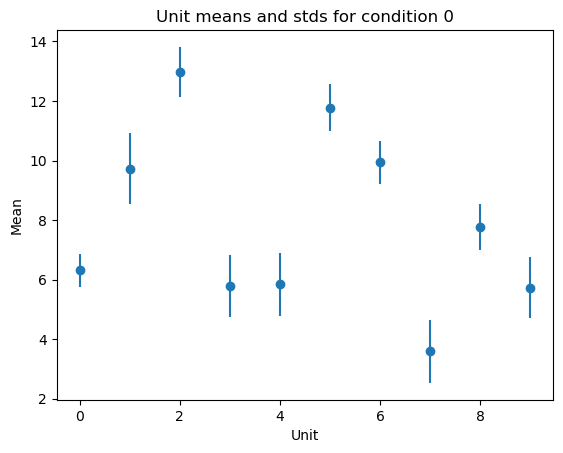

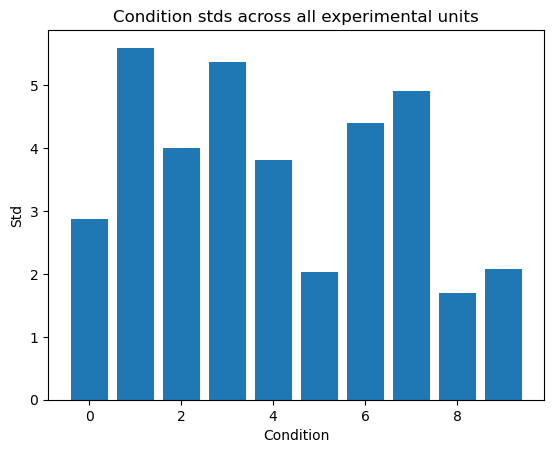

In [20]:
# set the index for the condition which will be observed
condition_index = 0

# compute the mean and std for each unit and condition
unit_mean = np.mean(dataset, axis=2)
unit_std = np.std(dataset, axis=2)

# compute the mean and std for each condition
condition_mean = np.mean(dataset, axis=2)
condition_std = np.std(condition_mean, axis=0)

# plot an errorbar plot to visualize the unit means and stds for the selected condition
plt.errorbar(
    np.arange(n_units),
    unit_mean[:, condition_index],
    yerr=unit_std[:, condition_index],
    fmt='o',
)
plt.title('Unit means and stds for condition {}'.format(condition_index))
plt.xlabel('Unit')
plt.ylabel('Mean')
plt.show()

# visualize the condition stds across all experimental units over the conditions
plt.bar(
    np.arange(n_conditions),
    condition_std,
)
plt.title('Condition stds across all experimental units')
plt.xlabel('Condition')
plt.ylabel('Std')
plt.show()

How would you expect the std to change for an increased amount of trials and/or noise?

Test your assumption by changing the value for the amount of trials and/or noise an re-run the code of this section!

What did you notice?

## Model parameter recovery

In this section we will take the previously generated dataset to fit a regression model from the ```sklearn``` package.

Here you will learn to:
- Prepare data for model fitting
- Use data to fit a model
- Get a feeling for the significance of noise and sample size on the quality of the recovered model

So first we need to prepare the data for the further steps.

This will be done by:
1. Creating a 2D observations matrix of the shape `(samples, features)`
1. Creating a 2D conditions matrix of the length of the data matrix of the shape `(samples, features)`
1. Concatenating the observations and the conditions along the `features` axis
1. Shuffling along the the `samples` axis to break up any correlations other than condition-observation
1. Splitting the data into training and test data
    - Training data is used for fitting the model
    - Test data is used for evaluating the model's generalization capability and making sure it did not simply learn the samples (i.e. overfitting)

In [21]:
# Convert the data to a matrix
conditions_recovery = conditions.repeat(n_repetitions, axis=0)  # repeat the single conditions as they have been presented to each unit n_repetitions times
conditions_recovery = np.stack([conditions_recovery] * n_units, axis=0)  # stack the conditions for each unit
conditions_recovery = conditions_recovery.reshape(-1, 2)  # flatten the conditions to create a 2D matrix. The first axis is n_units * n_conditions * n_repetitions and the second axis is len(conditions)
observations_recovery = dataset.flatten().reshape(-1, 1)  # flatten (shape -> (-1,)) and reshape (shape -> (-1, len(response)))) the responses to create a 2D vector. The first axis is n_units * n_conditions * n_repetitions and the second axis is len(response)

# Concatenate the conditions and the observations
data_recovery = np.concatenate((conditions_recovery, observations_recovery), axis=1)

# Shuffle the data
np.random.shuffle(data_recovery)

# Split the data into train and test data
train_ratio = 0.8  # define the amount of data which will be used for training
train_data = data_recovery[:int(len(data_recovery) * train_ratio)]  # take the first train_ratio*100% of the data for training
test_data = data_recovery[int(len(data_recovery) * train_ratio):]  # take the remaining data for testing

Next we need to implement the model fitting algorithm.

To do that, we will use a simple linear regression estimator from the sklearn package.

In [22]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(train_data[:, :conditions_recovery.shape[-1]], train_data[:, conditions_recovery.shape[-1]:])

# Recovered parameters
recovered_a = model.coef_[0, 0]
recovered_b = model.coef_[0, 1]

# print the recovered parameters
a_true = np.round(np.mean(parameters[:, 0]), 3)
b_true = np.round(np.mean(parameters[:, 1]), 3)
print('After running experiments on {} units with {} conditions and {} repetitions per condition, we recovered the following parameters:'.format(n_units, n_conditions, n_repetitions))
print('True parameters (mean across all units): a = {}, b = {}'.format(a_true, b_true))
print('Recovered parameters: a = {}, b = {}'.format(np.round(recovered_a, 3), np.round(recovered_b, 3)))

After running experiments on 10 units with 10 conditions and 10 repetitions per condition, we recovered the following parameters:
True parameters (mean across all units): a = 2.055, b = 2.382
Recovered parameters: a = 2.046, b = 2.412


Now we are going to test the fitted model with the test data.
We will compute the prediction accuracy with a sklearn metric

In [23]:
from sklearn.metrics import mean_squared_error

# use the fitted model to predict the test observations
observations_predicted = model.predict(test_data[:, :conditions_recovery.shape[-1]])

# compute the means of the two datasets
original_mean = np.mean(test_data[:, conditions_recovery.shape[-1]:]) 
recovered_mean = np.mean(observations_predicted)

# compute prediciton error
prediction_accuracy = mean_squared_error(test_data[:, conditions_recovery.shape[-1]:], observations_predicted)
print('Mean absolute error: {}'.format(prediction_accuracy))

# compare the means
print('Original mean: {}'.format(original_mean))
print('Recovered mean: {}'.format(recovered_mean))

Mean absolute error: 15.070629344064594
Original mean: 21.78275788835306
Recovered mean: 21.691931761751793


How does the result on the test data look like?

A small error - compared to the average amplitude of the observation - is acceptable since it's difficult to get a perfect match. For most cases it's even impossible.

Get a feeling for the significance of noise and sample size on the quality of a fitted model and its predictive power by adjusting the number of units, conditions, repitions and also the noise level.

## Congratulations!

You finished the first tutorial.

Now you should have a good idea about:
- How to implement a synthetic experiment
- How to get unit-to-unit and trial-to-trial variation into your dataset
- How the sample size and noise affects the recovery of parameters